# Lab 05 : GatedGCNs with DGL - demo


Deep Graph Library (DGL) 

https://docs.dgl.ai/


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import dgl
from dgl import DGLGraph
from dgl.data import MiniGCDataset

import time
import numpy as np
import networkx as nx

import os
import pickle

import matplotlib.pyplot as plt
%matplotlib inline 


In [2]:

# select GPU for notebook
gpu_id = 0  
server_id = 186
    
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)  

if torch.cuda.is_available():
    print('cuda available with GPU:',torch.cuda.get_device_name(0))
    dtypeFloat = torch.cuda.FloatTensor
    dtypeLong = torch.cuda.LongTensor
else:
    print('cuda not available')
    gpu_id = -1
    server_id = -1
    dtypeFloat = torch.FloatTensor
    dtypeLong = torch.LongTensor
    
# GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")


cuda not available


# Create dataset of graphs

In [3]:

def collate(samples):
    # The input samples is a list of pairs (graph, label).
    graphs, labels = map(list, zip(*samples))
    labels = torch.tensor(labels)
    tab_sizes_n = [ graphs[i].number_of_nodes() for i in range(len(graphs))]
    tab_snorm_n = [ torch.FloatTensor(size,1).fill_(1./float(size)) for size in tab_sizes_n ]
    snorm_n = torch.cat(tab_snorm_n).sqrt()  
    tab_sizes_e = [ graphs[i].number_of_edges() for i in range(len(graphs))]
    tab_snorm_e = [ torch.FloatTensor(size,1).fill_(1./float(size)) for size in tab_sizes_e ]
    snorm_e = torch.cat(tab_snorm_e).sqrt()
    batched_graph = dgl.batch(graphs)
    return batched_graph, labels, snorm_n, snorm_e


def create_artificial_features(dataset):
    for (graph,_) in dataset:
        graph.ndata['feat'] = graph.in_degrees().view(-1, 1).float()
        graph.edata['feat'] = torch.ones(graph.number_of_edges(),1)
    return dataset


trainset = MiniGCDataset(2, 10, 20)
print(trainset)
batched_graph, labels, snorm_n, snorm_e = collate(trainset)



In [4]:

save_dataset = False
#save_dataset = True
data_folder = 'data/'
if save_dataset == True:
    
    # Train
    trainset = MiniGCDataset(350, 10, 20)
    testset = MiniGCDataset(100, 10, 20)
    valset = MiniGCDataset(100, 10, 20)
    data_loader = DataLoader(trainset, batch_size=20, shuffle=True, collate_fn=collate)

    trainset = create_artificial_features(trainset)
    testset = create_artificial_features(testset)
    valset = create_artificial_features(valset)

    with open(data_folder + "artificial_dataset.pickle","wb") as f:
        pickle.dump([trainset,testset,valset],f)
        
else:
    
    with open(data_folder + "artificial_dataset.pickle","rb") as f:
        f = pickle.load(f)
        trainset = f[0]
        testset = f[1]
        valset = f[1]
    print(len(trainset),len(testset),len(valset))


350 100 100


# Visualize

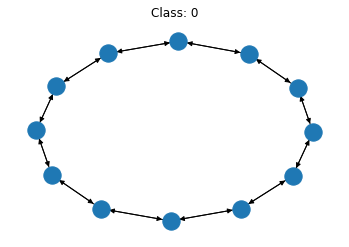

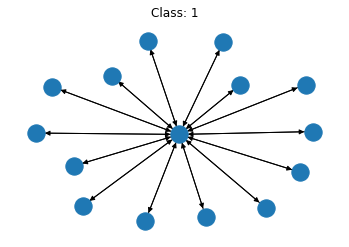

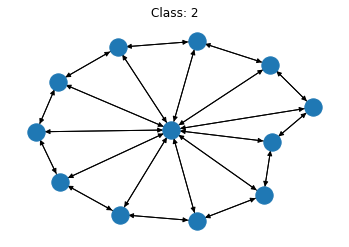

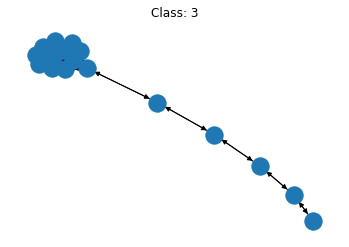

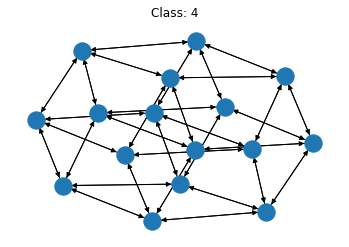

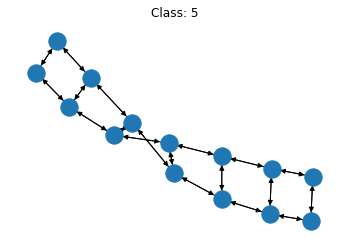

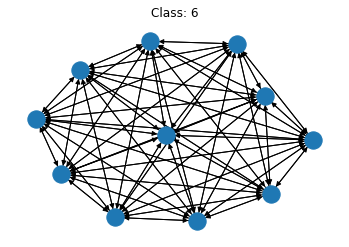

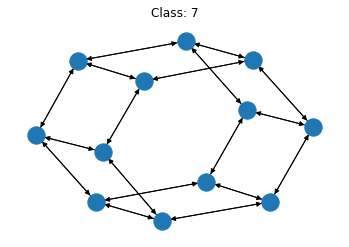

In [5]:

visualset = MiniGCDataset(8, 10, 20)

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
    
for c in range(8):
    graph, label = visualset[c] 
    fig, ax = plt.subplots()
    nx.draw(graph.to_networkx(), ax=ax)
    ax.set_title('Class: {:d}'.format(label))
    plt.show()


# Define the following graph convnet network

\begin{eqnarray}
h_i^{\ell+1} &=& h_i^{\ell} + \text{ReLU} \left( A^\ell h_i^{\ell} + \frac{1}{n(j)} \sum_{j\sim i} \sigma(e_{ij}^{\ell}) \odot B^\ell h_j^{\ell} \right) \\
e_{ij}^{\ell+1} &=& e^\ell_{ij} + \text{ReLU} \Big( C^\ell e_{ij}^{\ell} + D^\ell h^{\ell+1}_i + E^\ell h^{\ell+1}_j  \Big)
\end{eqnarray}

Ref: X Bresson, T Laurent, Residual gated graph convnets, arXiv preprint arXiv:1711.07553

In [6]:

class MLP_layer(nn.Module):
    
    def __init__(self, input_dim, output_dim, L=2): #L=nb_hidden_layers
        super(MLP_layer, self).__init__()
        list_FC_layers = [ nn.Linear( input_dim//2**l , input_dim//2**(l+1) , bias=True ) for l in range(L) ]
        list_FC_layers.append(nn.Linear( input_dim//2**L , output_dim , bias=True ))
        self.FC_layers = nn.ModuleList(list_FC_layers)
        self.L = L
        
    def forward(self, x):
        y = x
        for l in range(self.L):
            y = self.FC_layers[l](y)
            y = F.relu(y)
        y = self.FC_layers[self.L](y)
        return y

        
        
class basic_GatedConvNet_layer(nn.Module):
    
    def __init__(self, input_dim, output_dim):
        super(basic_GatedConvNet_layer, self).__init__()
        self.A = nn.Linear(input_dim, output_dim, bias=True)
        self.B = nn.Linear(input_dim, output_dim, bias=True)
        self.C = nn.Linear(input_dim, output_dim, bias=True)
        self.D = nn.Linear(input_dim, output_dim, bias=True)
        self.E = nn.Linear(input_dim, output_dim, bias=True)
        self.bn_node_h = nn.BatchNorm1d(output_dim)
        self.bn_node_e = nn.BatchNorm1d(output_dim)

    def message_func(self, edges):
        Bh_j = edges.src['Bh']    
        e_ij = edges.data['Ce'] +  edges.src['Dh'] + edges.dst['Eh'] # e_ij = Ce_ij + Dhi + Ehj
        edges.data['e'] = e_ij
        return {'Bh_j' : Bh_j, 'e_ij' : e_ij}

    def reduce_func(self, nodes):
        Ah_i = nodes.data['Ah']
        Bh_j = nodes.mailbox['Bh_j']
        e = nodes.mailbox['e_ij'] 
        sigma_ij = torch.sigmoid(e) # sigma_ij = sigmoid(e_ij)
        h = Ah_i + torch.mean( sigma_ij * Bh_j, dim=1 ) # hi = Ahi + mean_j alpha_ij * Bhj    
        return {'h' : h}
    
    def forward(self, g, h, e, snorm_n, snorm_e):
        
        h_in = h # residual connection
        e_in = e # residual connection
        
        g.ndata['h']  = h 
        g.ndata['Ah'] = self.A(h) 
        g.ndata['Bh'] = self.B(h) 
        g.ndata['Dh'] = self.D(h)
        g.ndata['Eh'] = self.E(h) 
        g.edata['e']  = e 
        g.edata['Ce'] = self.C(e) 
        g.update_all(self.message_func,self.reduce_func) 
        h = g.ndata['h'] # result of graph convolution
        e = g.edata['e'] # result of graph convolution
        
        h = h* snorm_n # normalize activation w.r.t. graph size
        e = e* snorm_e # normalize activation w.r.t. graph size
        
        h = self.bn_node_h(h) # batch normalization  
        e = self.bn_node_e(e) # batch normalization  
        
        h = F.relu(h) # non-linear activation
        e = F.relu(e) # non-linear activation
        
        h = h_in + h # residual connection
        e = e_in + e # residual connection
        
        return h, e
    
    
class GNN_Net(nn.Module):
    
    def __init__(self, net_parameters):
        super(GNN_Net, self).__init__()
        input_dim = net_parameters['input_dim']
        hidden_dim = net_parameters['hidden_dim']
        output_dim = net_parameters['output_dim']
        L = net_parameters['L']
        self.embedding_h = nn.Linear(input_dim, hidden_dim)
        self.embedding_e = nn.Linear(1, hidden_dim)
        self.gnn_layers = nn.ModuleList([ basic_GatedConvNet_layer(hidden_dim, hidden_dim) for _ in range(L) ]) 
        self.MLP_layer = MLP_layer(hidden_dim, output_dim)
        
    def forward(self, g, h, e, snorm_n, snorm_e):
        
        # input embedding
        h = self.embedding_h(h)
        e = self.embedding_e(e)
        
        # convnets
        for gnn_layer in self.gnn_layers:
            h,e = gnn_layer(g,h,e,snorm_n,snorm_e)
        
        # MLP
        g.ndata['h'] = h
        y = dgl.mean_nodes(g,'h')
        y = self.MLP_layer(y)
        
        return y    
    
    def loss(self, y_scores, y_labels):
        loss = nn.CrossEntropyLoss()(y_scores, y_labels)
        return loss        
        
    def accuracy(self, scores, targets):
        scores = scores.detach().argmax(dim=1)
        acc = (scores==targets).float().sum().item()
        return acc
    
    def gpu_memory(self, memory):
        if torch.cuda.is_available():
            current_memory = torch.cuda.memory_allocated() /1e9
            if current_memory > memory :
                memory = current_memory
        return memory
    
    def update(self, lr):       
        update = torch.optim.Adam( self.parameters(), lr=lr )
        return update
    
    def update_learning_rate(self, optimizer, lr):
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        return optimizer
    

    

# network parameters
input_dim = 1 
hidden_dim = 100
output_dim = 8
L = 2
net_parameters = {}
net_parameters['input_dim'] = input_dim
net_parameters['hidden_dim'] = hidden_dim
net_parameters['output_dim'] = output_dim
net_parameters['L'] = L

# instantiate network
net = GNN_Net(net_parameters)
net = net.to(device)
print(net)


GNN_Net(
  (embedding_h): Linear(in_features=1, out_features=100, bias=True)
  (embedding_e): Linear(in_features=1, out_features=100, bias=True)
  (gnn_layers): ModuleList(
    (0): basic_GatedConvNet_layer(
      (A): Linear(in_features=100, out_features=100, bias=True)
      (B): Linear(in_features=100, out_features=100, bias=True)
      (C): Linear(in_features=100, out_features=100, bias=True)
      (D): Linear(in_features=100, out_features=100, bias=True)
      (E): Linear(in_features=100, out_features=100, bias=True)
      (bn_node_h): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn_node_e): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): basic_GatedConvNet_layer(
      (A): Linear(in_features=100, out_features=100, bias=True)
      (B): Linear(in_features=100, out_features=100, bias=True)
      (C): Linear(in_features=100, out_features=100, bias=True)
      (D): Linear(in_features=100, out_

# Test forward pass

In [7]:

train_loader = DataLoader(trainset, batch_size=10, shuffle=True, collate_fn=collate)
batch_graphs, batch_labels, batch_snorm_n, batch_snorm_e = list(train_loader)[0]
print(batch_graphs)
print(batch_labels)
print(batch_snorm_n.size())
print(batch_snorm_e.size())

batch_x = batch_graphs.ndata['feat'].to(device)
print('batch_x',batch_x.size())
#print(batch_x)

batch_e = batch_graphs.edata['feat'].to(device)
print('batch_e',batch_e.size())
#print(batch_e)

batch_snorm_n = batch_snorm_n.to(device)
print('batch_snorm_n',batch_snorm_n.size())

batch_snorm_e = batch_snorm_e.to(device)
print('batch_snorm_e',batch_snorm_e.size())

batch_scores = net.forward(batch_graphs, batch_x, batch_e, batch_snorm_n, batch_snorm_e)
print(batch_scores.size())

batch_labels = batch_labels.to(device)
accuracy = net.accuracy(batch_scores,batch_labels)
print(accuracy)


DGLGraph(num_nodes=142, num_edges=1136,
         ndata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)})
tensor([2, 6, 3, 6, 6, 5, 1, 2, 1, 6])
torch.Size([142, 1])
torch.Size([1136, 1])
batch_x torch.Size([142, 1])
batch_e torch.Size([1136, 1])
batch_snorm_n torch.Size([142, 1])
batch_snorm_e torch.Size([1136, 1])
torch.Size([10, 8])
3.0


# Test backward pass

In [8]:

# optimization parameters
opt_parameters = {}
opt_parameters['lr'] = 0.0005

# Loss
loss = net.loss(batch_scores, batch_labels)

# Backward pass
lr = opt_parameters['lr']
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
optimizer.zero_grad()
loss.backward()
optimizer.step()


# Train one epoch

In [9]:

def train_one_epoch(net, data_loader):
    """
    train one epoch
    """
    net.train()
    epoch_loss = 0
    epoch_train_acc = 0
    nb_data = 0
    gpu_mem = 0
    for iter, (batch_graphs, batch_labels, batch_snorm_n, batch_snorm_e) in enumerate(data_loader):
        batch_x = batch_graphs.ndata['feat'].to(device)
        batch_e = batch_graphs.edata['feat'].to(device)
        batch_snorm_n = batch_snorm_n.to(device)
        batch_snorm_e = batch_snorm_e.to(device)
        batch_labels = batch_labels.to(device)
        batch_scores = net.forward(batch_graphs, batch_x, batch_e, batch_snorm_n, batch_snorm_e)
        gpu_mem = net.gpu_memory(gpu_mem)
        loss = net.loss(batch_scores, batch_labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach().item()
        epoch_train_acc += net.accuracy(batch_scores,batch_labels)
        nb_data += batch_labels.size(0)
    epoch_loss /= (iter + 1)
    epoch_train_acc /= nb_data
    return epoch_loss, epoch_train_acc, gpu_mem  


# Evaluation

In [10]:

def evaluate_network(net, data_loader):
    """
    evaluate test set
    """
    net.eval()
    epoch_test_loss = 0
    epoch_test_acc = 0
    nb_data = 0
    with torch.no_grad():
        for iter, (batch_graphs, batch_labels, batch_snorm_n, batch_snorm_e) in enumerate(data_loader):
            batch_x = batch_graphs.ndata['feat'].to(device)
            batch_e = batch_graphs.edata['feat'].to(device)
            batch_snorm_n = batch_snorm_n.to(device)
            batch_snorm_e = batch_snorm_e.to(device)
            batch_labels = batch_labels.to(device)
            batch_scores = net.forward(batch_graphs, batch_x, batch_e, batch_snorm_n, batch_snorm_e)
            loss = net.loss(batch_scores, batch_labels)
            epoch_test_loss += loss.detach().item()
            epoch_test_acc += net.accuracy(batch_scores,batch_labels)
            nb_data += batch_labels.size(0)
        epoch_test_loss /= (iter + 1)
        epoch_test_acc /= nb_data
    return epoch_test_loss, epoch_test_acc
    

# Train GNN

In [13]:

# datasets
train_loader = DataLoader(trainset, batch_size=50, shuffle=True, collate_fn=collate)
test_loader = DataLoader(testset, batch_size=50, shuffle=False, collate_fn=collate)
val_loader = DataLoader(valset, batch_size=50, shuffle=False, drop_last=False, collate_fn=collate)

# Create model
net_parameters = {}
net_parameters['input_dim'] = 1
net_parameters['hidden_dim'] = 100
net_parameters['output_dim'] = 8
net_parameters['L'] = 4
net = GNN_Net(net_parameters)
net = net.to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=0.0005)

epoch_train_losses = []
epoch_test_losses = []
epoch_val_losses = []
epoch_train_accs = []
epoch_test_accs = []
epoch_val_accs = []
for epoch in range(30):
    
    start = time.time()
    epoch_train_loss, epoch_train_acc, gpu_mem = train_one_epoch(net, train_loader)
    epoch_test_loss, epoch_test_acc = evaluate_network(net, test_loader)
    epoch_val_loss, epoch_val_acc = evaluate_network(net, val_loader)
        
    epoch_train_losses.append(epoch_train_loss)
    epoch_test_losses.append(epoch_test_loss)
    epoch_val_losses.append(epoch_val_loss)
    epoch_train_accs.append(epoch_train_acc)
    epoch_test_accs.append(epoch_test_acc)
    epoch_val_accs.append(epoch_val_acc)
    
    print('Epoch {}, time {:.4f}, train_loss: {:.4f}, test_loss: {:.4f}, val_loss: {:.4f} \n                     train_acc: {:.4f}, test_acc: {:.4f}, val_acc: {:.4f}'.format(epoch, time.time()-start, epoch_train_loss, epoch_test_loss, epoch_val_loss, epoch_train_acc, epoch_test_acc, epoch_val_acc))
    

Epoch 0, time 2.0785, train_loss: 2.0631, test_loss: 2.0748, val_loss: 2.0748 
                     train_acc: 0.2000, test_acc: 0.1200, val_acc: 0.1200
Epoch 1, time 2.0832, train_loss: 1.8007, test_loss: 1.9643, val_loss: 1.9643 
                     train_acc: 0.4257, test_acc: 0.2600, val_acc: 0.2600
Epoch 2, time 2.0827, train_loss: 1.6563, test_loss: 1.7956, val_loss: 1.7956 
                     train_acc: 0.5857, test_acc: 0.3200, val_acc: 0.3200
Epoch 3, time 2.2513, train_loss: 1.5387, test_loss: 1.6317, val_loss: 1.6317 
                     train_acc: 0.6171, test_acc: 0.6000, val_acc: 0.6000
Epoch 4, time 2.1797, train_loss: 1.3881, test_loss: 1.4765, val_loss: 1.4765 
                     train_acc: 0.6857, test_acc: 0.6900, val_acc: 0.6900
Epoch 5, time 2.1258, train_loss: 1.2690, test_loss: 1.3054, val_loss: 1.3054 
                     train_acc: 0.6886, test_acc: 0.6700, val_acc: 0.6700
Epoch 6, time 2.1135, train_loss: 1.1654, test_loss: 1.2040, val_loss: 1.2040 
   